In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import csv
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
%matplotlib inline
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import cv2


In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = 'e3c11603b207c8253d21825eae59c7bc'
os.environ["KAGGLE_USERNAME"] = 'gauravmanish834'

!kaggle datasets download -d jessicali9530/lfw-dataset


!unzip "lfw-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Si

In [3]:
def compute_hog(img):
  #resizing image
  resized_img = resize(img, (128*4, 64*4))
  #creating hog features
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)
  return fd


In [4]:

lfw_folder = '/content/lfw-deepfunneled/lfw-deepfunneled'
X, y = [],[]
for folder_name in os.listdir(lfw_folder):
    folder_path = os.path.join(lfw_folder, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        if num_images > 70:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = imread(image_path)
                hog_feature = compute_hog(image)
                # lbp_feature = calcLBP(image)
                # cnn_feature = extract_features(image_path, resnet).numpy()
                # hog_feature = hog_feature.reshape(-1)
                # lbp_feature = lbp_feature.reshape(-1)
                hog_feature = hog_feature.flatten()
                # combined_feature = np.concatenate((cnn_feature))

                X.append(hog_feature)
                y.append(folder_name)

In [5]:
X=np.array(X)
y=np.array(y)

In [6]:
y.shape

(1288,)

In [7]:
X

array([[0.41049533, 0.09369607, 0.02892379, ..., 0.01775232, 0.01150366,
        0.05084934],
       [0.34345736, 0.01401552, 0.02009561, ..., 0.06912227, 0.07671495,
        0.19960103],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.13687706, 0.        , 0.        , ..., 0.        , 0.04661944,
        0.12364048],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [8]:
X.shape

(1288, 70308)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

# Fit the LDA model to the data
X_train=lda.fit_transform(X_train, y_train)
X_test=lda.transform(X_test)

In [11]:
X.shape

(1288, 70308)

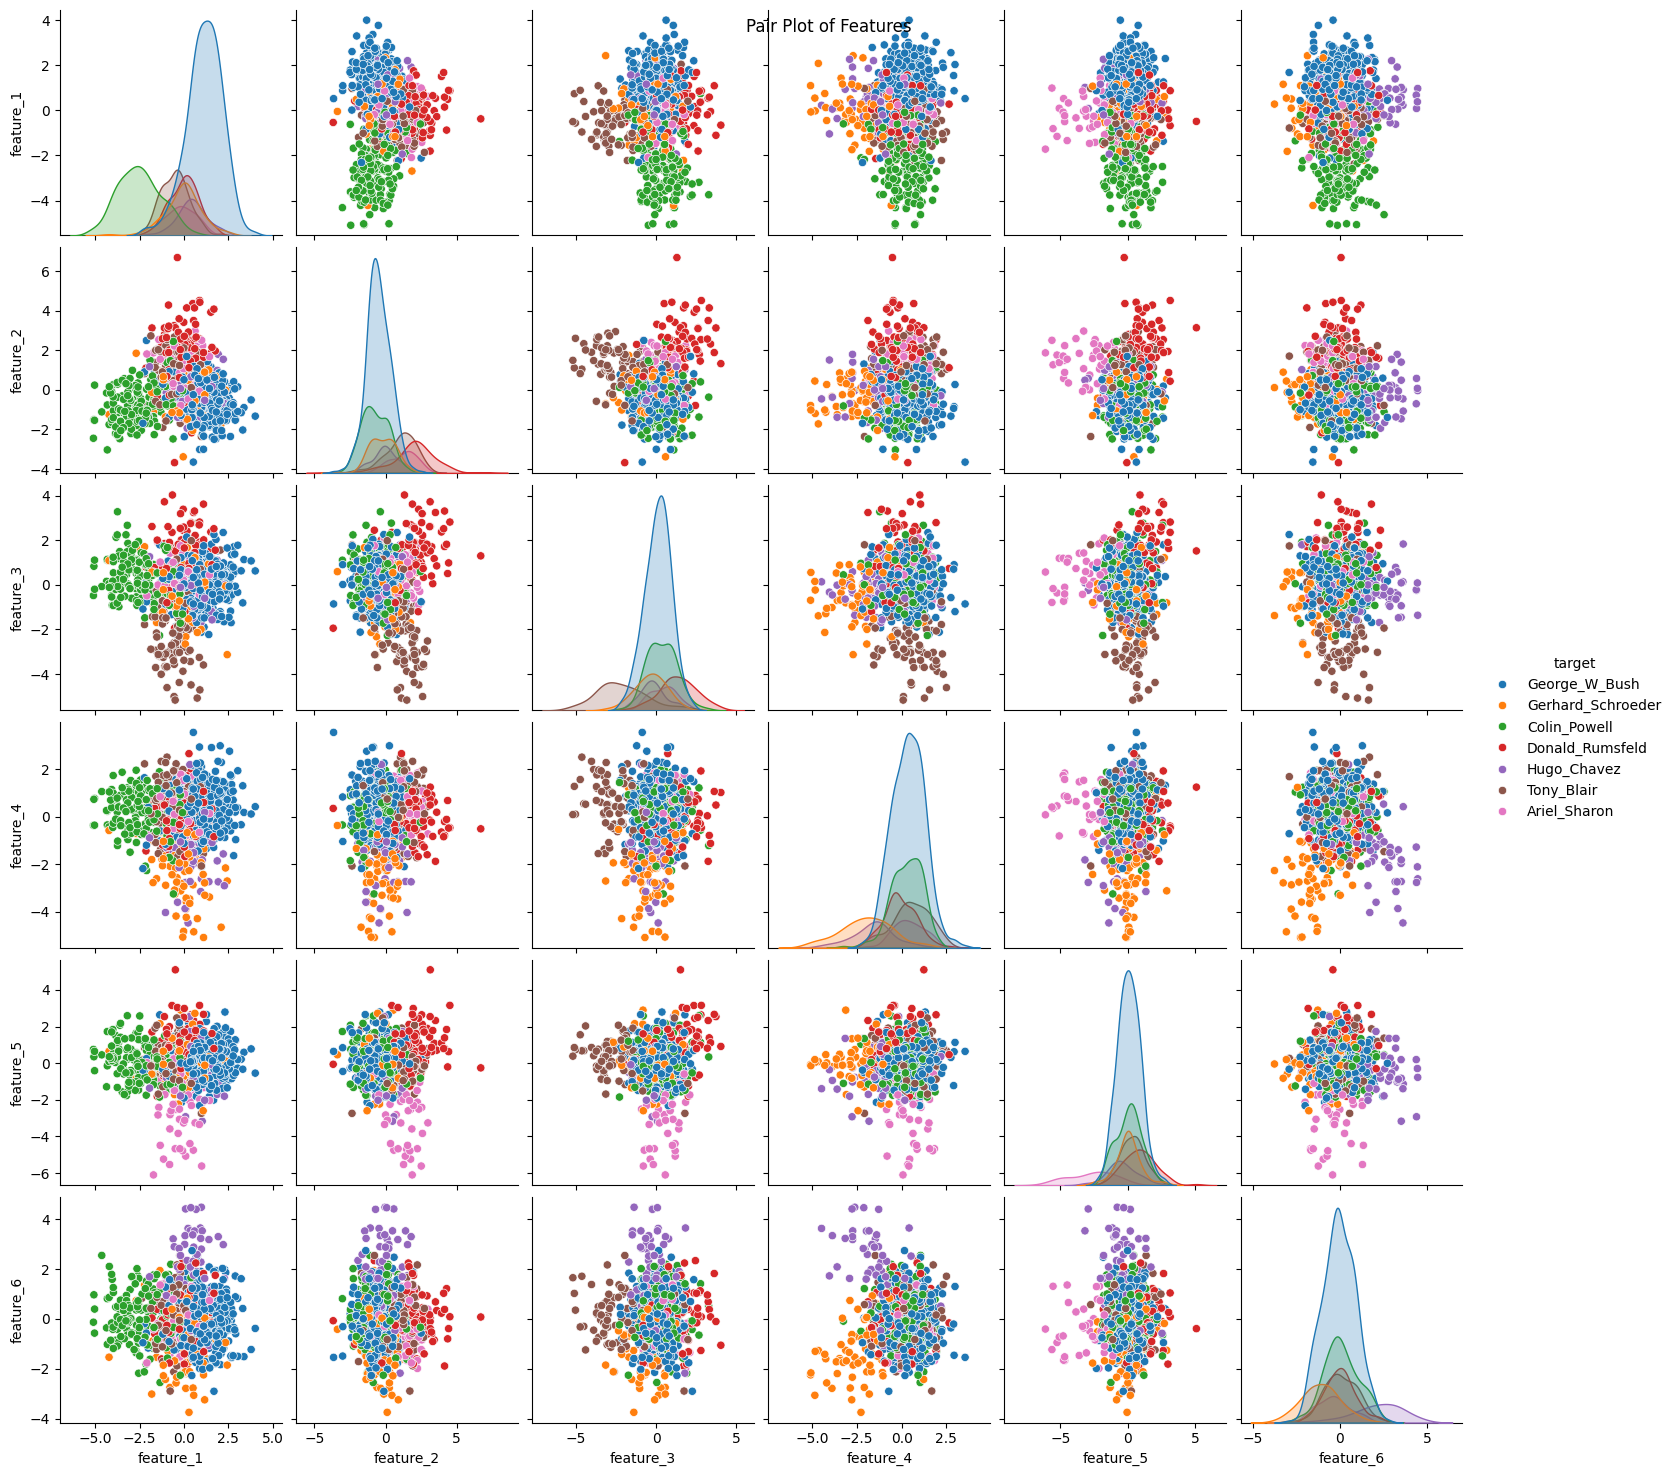

In [12]:
import seaborn as sns

# Convert training data to DataFrame for visualization
import pandas as pd
X_train_df = pd.DataFrame(X_train, columns=[f'feature_{i+1}' for i in range(X_train.shape[1])])
X_train_df['target'] = y_train

# Pair plot
sns.pairplot(X_train_df, hue='target', diag_kind='kde')
plt.suptitle("Pair Plot of Features")
plt.show()



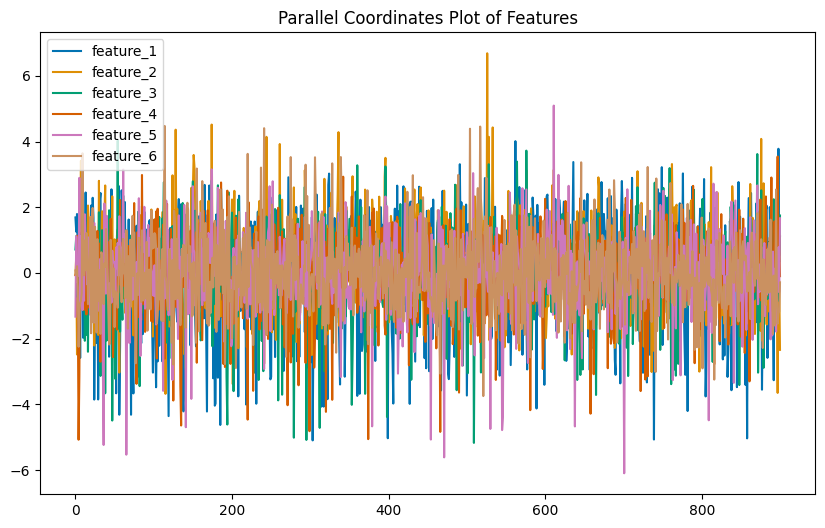

In [13]:
# Parallel coordinates plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=X_train_df.drop(columns='target'), dashes=False, palette='colorblind')
plt.title("Parallel Coordinates Plot of Features")
plt.show()


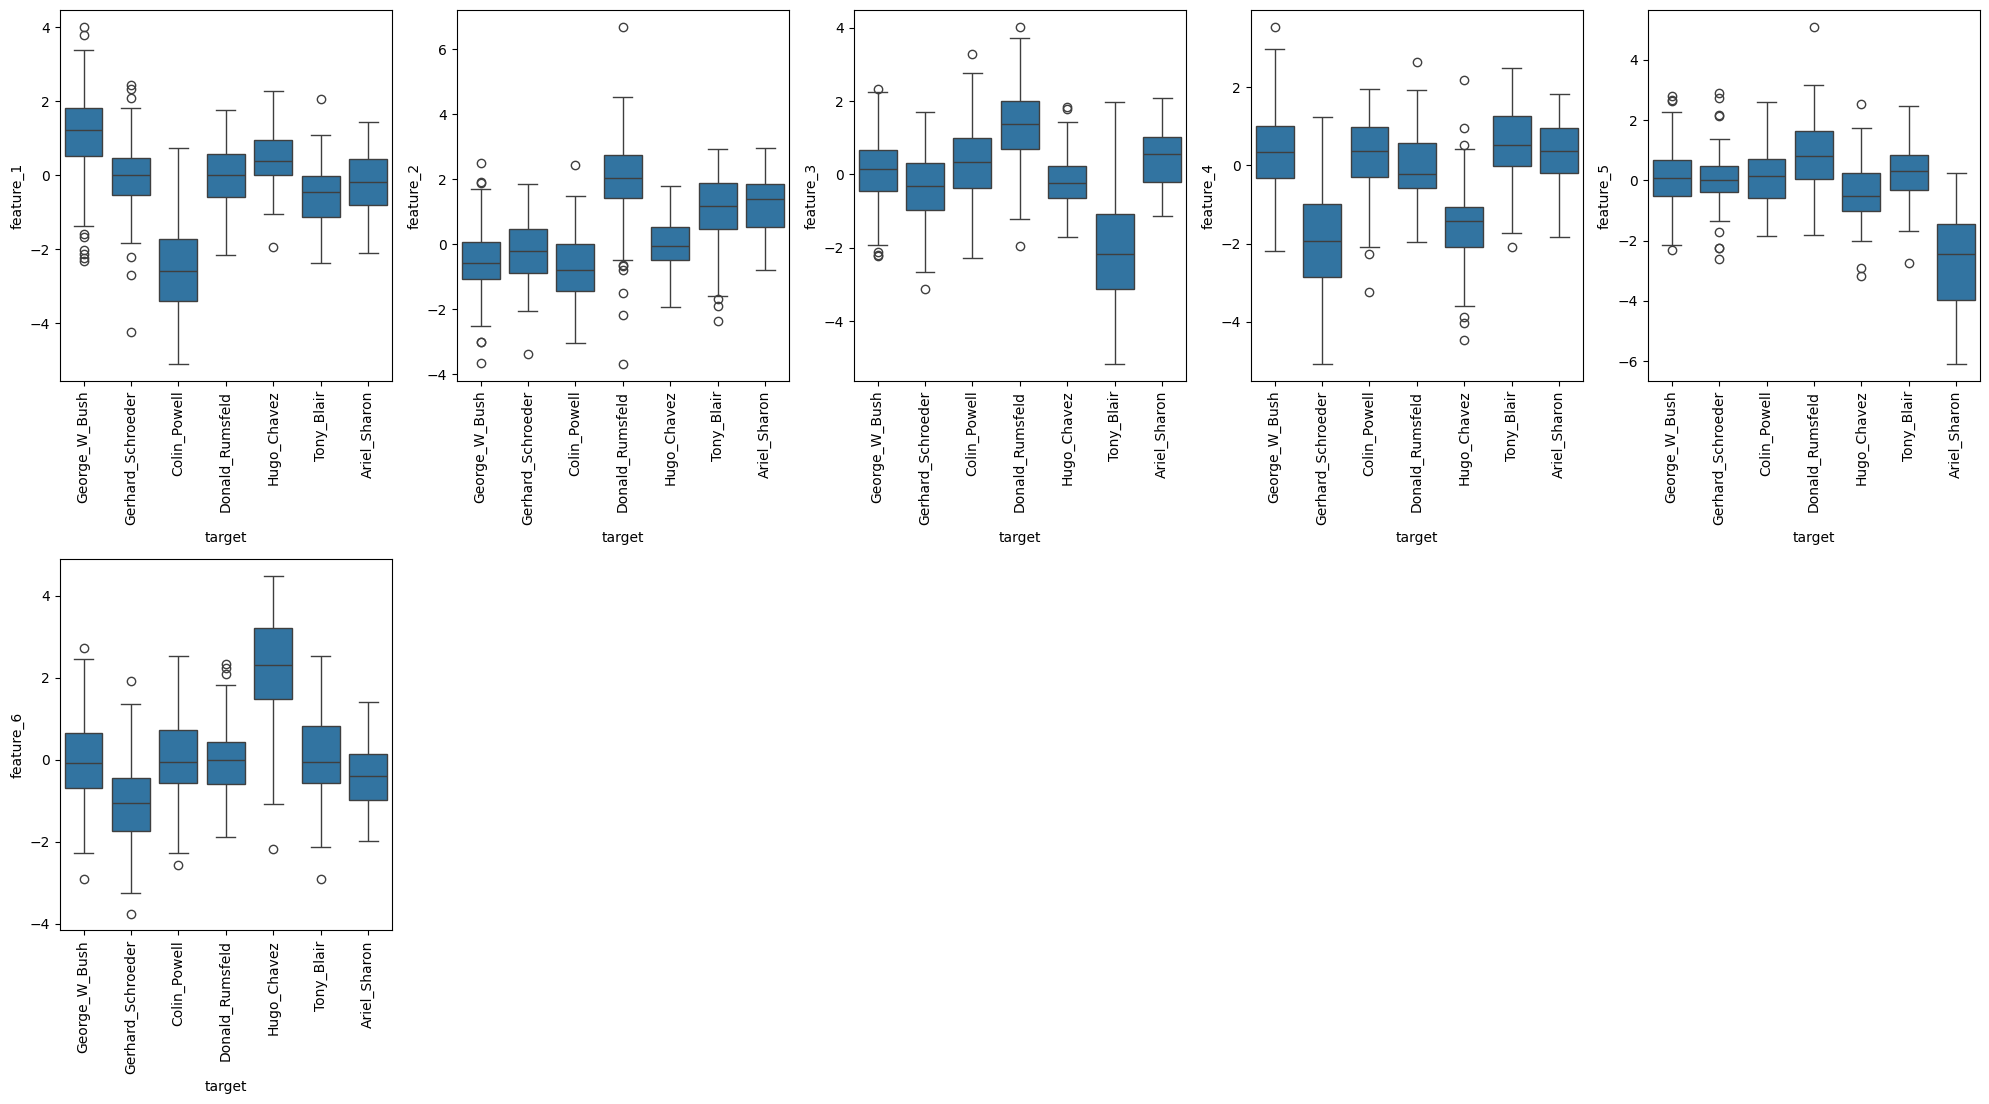

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Set a larger figure size
plt.figure(figsize=(20, 15))

# Convert training data to DataFrame for visualization
X_train_df = pd.DataFrame(X_train, columns=[f'feature_{i+1}' for i in range(X_train.shape[1])])
X_train_df['target'] = y_train

# Plot box plots for each feature
for i in range(X_train.shape[1]):
    plt.subplot(3, 5, i+1)  # Adjust the subplot size for larger plots
    sns.boxplot(x='target', y=f'feature_{i+1}', data=X_train_df)

    # Rotate x-axis labels vertically
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()



In [15]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()


In [16]:
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31,4))
weights=["uniform", "distance"]
param_grid = dict(n_neighbors=k_range ,weights=weights)
grid = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 9, 13, 17, 21, 25, 29],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [17]:
y_pred=grid.predict(X_test)

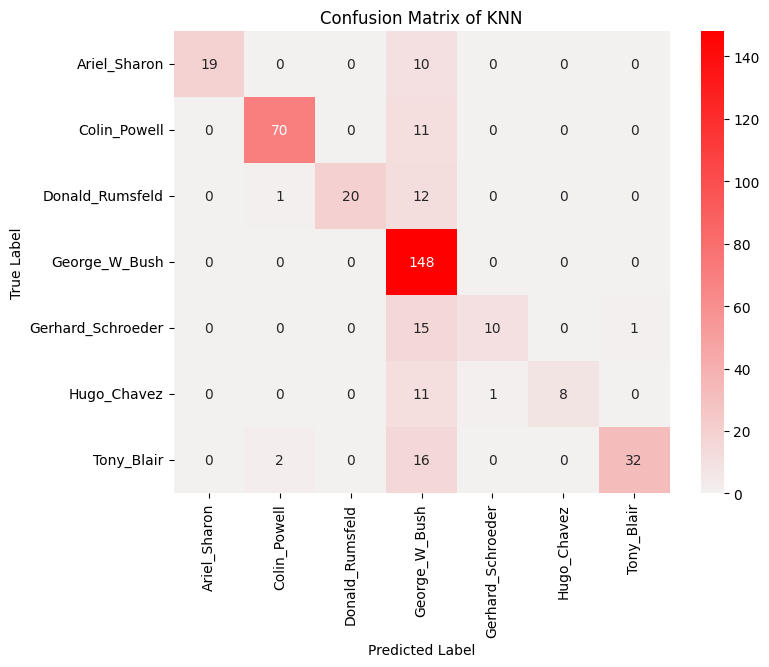

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of KNN')
plt.show()


In [19]:
nn=grid.best_params_

In [20]:
from sklearn.metrics import accuracy_score
print("accuracy score whith knn with n_neighbors=",nn['n_neighbors'],"(best case) is:",accuracy_score(y_test, y_pred))

accuracy score whith knn with n_neighbors= 13 (best case) is: 0.7932816537467701


In [21]:
from sklearn.linear_model import LogisticRegression

# Define logistic regression classifier
logistic_regression = LogisticRegression(max_iter=200)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Penalty term
}

# Create GridSearchCV object
grid_logistic_regression = GridSearchCV(logistic_regression, param_grid, cv=10, scoring='accuracy', return_train_score=False)

# Fit the model to the training data
grid_logistic_regression.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=200),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [22]:
y_pred = grid_logistic_regression.predict(X_test)

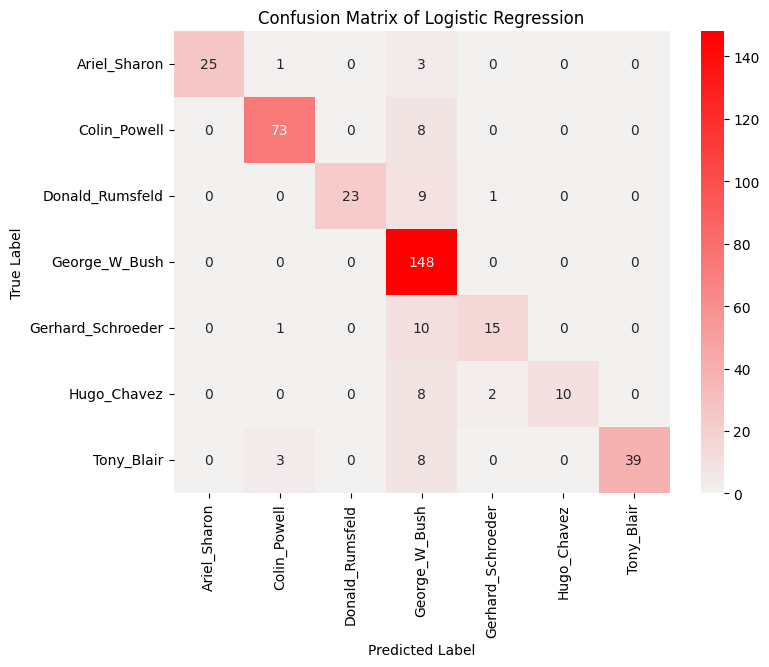

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Logistic Regression')
plt.show()


In [24]:
# Print the best parameters and best score
print("Best parameters found: ", grid_logistic_regression.best_params_)
print("Best accuracy found: ", accuracy_score(y_pred,y_test))

Best parameters found:  {'C': 10, 'penalty': 'l2'}
Best accuracy found:  0.8604651162790697


In [25]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=141,max_depth=61,min_samples_split=2,min_samples_leaf=5)
rf_classifier.fit(X_train,y_train)
y_pred_rf = rf_classifier.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred_rf))

0.8217054263565892


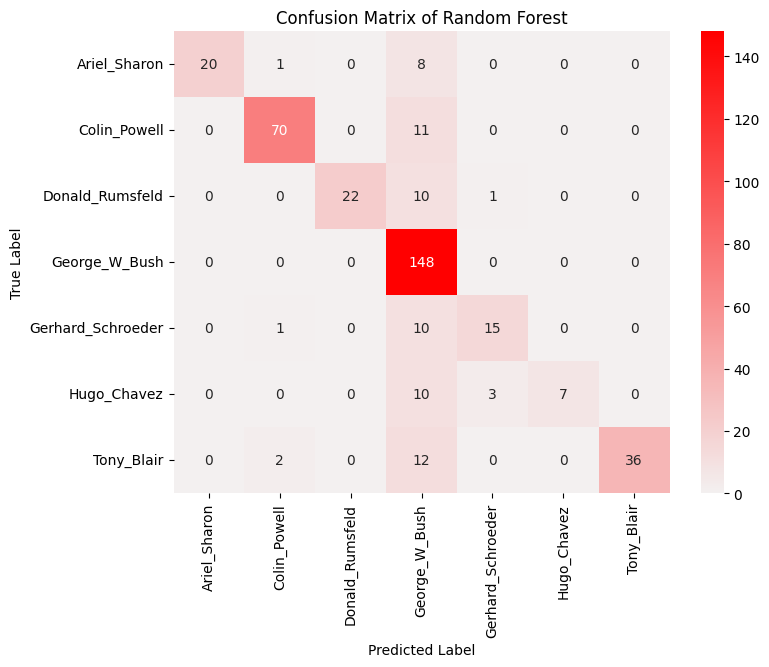

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Random Forest')
plt.show()


In [27]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=10)
}
from sklearn.model_selection import GridSearchCV
nbModel_grid = GridSearchCV(gnb, param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)




Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
             verbose=1)

In [28]:
y_pred=nbModel_grid.predict(X_test)

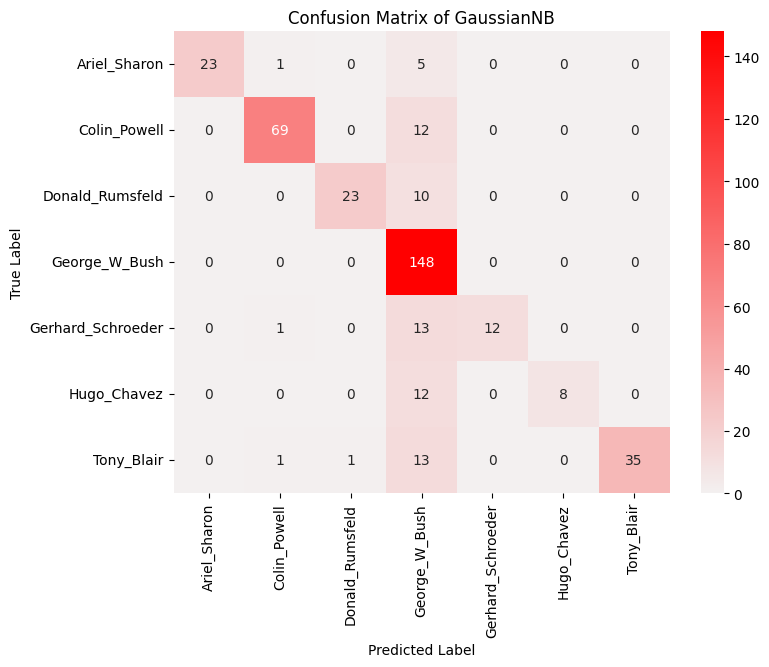

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of GaussianNB')
plt.show()


In [30]:
print("Accuracy score with Gaussian Naive Bias after implementation of Grid search",accuracy_score(y_test,y_pred))



Accuracy score with Gaussian Naive Bias after implementation of Grid search 0.8217054263565892


In [31]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Linear SVM
svm_linear = SVC(kernel='linear',C=1)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)
print("Linear SVM Classification Report:")
print(classification_report(y_test, y_pred_linear))
print(accuracy_score(y_test,y_pred_linear))

Linear SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.86      0.93        29
     Colin_Powell       0.95      0.88      0.91        81
  Donald_Rumsfeld       1.00      0.70      0.82        33
    George_W_Bush       0.72      1.00      0.84       148
Gerhard_Schroeder       0.93      0.54      0.68        26
      Hugo_Chavez       1.00      0.40      0.57        20
       Tony_Blair       1.00      0.72      0.84        50

         accuracy                           0.84       387
        macro avg       0.94      0.73      0.80       387
     weighted avg       0.88      0.84      0.83       387

0.8397932816537468


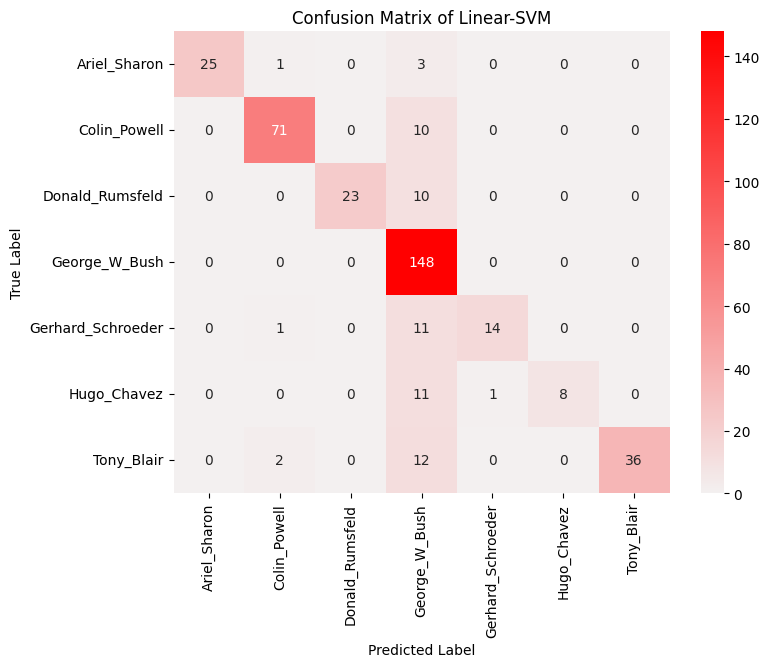

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_linear)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Linear-SVM')
plt.show()


In [33]:
# Polynomial SVM
svm_poly = SVC(kernel='poly', degree=2,C=1)  # You can adjust the degree parameter as needed
svm_poly.fit(X_train, y_train)
y_pred_poly = svm_poly.predict(X_test)
print("\nPolynomial SVM Classification Report:")
print(classification_report(y_test, y_pred_poly))
print(accuracy_score(y_test,y_pred_poly))



Polynomial SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.45      0.62        29
     Colin_Powell       0.96      0.54      0.69        81
  Donald_Rumsfeld       0.92      0.36      0.52        33
    George_W_Bush       0.52      0.99      0.68       148
Gerhard_Schroeder       1.00      0.15      0.27        26
      Hugo_Chavez       1.00      0.25      0.40        20
       Tony_Blair       1.00      0.48      0.65        50

         accuracy                           0.64       387
        macro avg       0.91      0.46      0.55       387
     weighted avg       0.80      0.64      0.62       387

0.6408268733850129


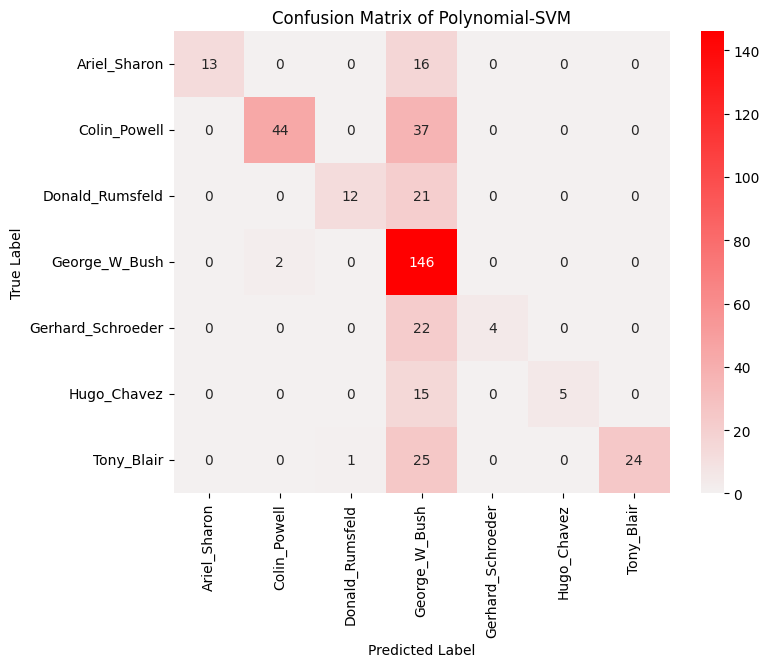

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_poly)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Polynomial-SVM')
plt.show()


In [35]:
# RBF SVM
svm_rbf = SVC(kernel='rbf',C=100,gamma=0.001)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
print("\nRBF SVM Classification Report:")
print(classification_report(y_test, y_pred_rbf))
print(accuracy_score(y_test,y_pred_rbf))


RBF SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.79      0.88        29
     Colin_Powell       0.93      0.86      0.90        81
  Donald_Rumsfeld       0.96      0.70      0.81        33
    George_W_Bush       0.71      1.00      0.83       148
Gerhard_Schroeder       0.93      0.50      0.65        26
      Hugo_Chavez       1.00      0.40      0.57        20
       Tony_Blair       1.00      0.70      0.82        50

         accuracy                           0.83       387
        macro avg       0.93      0.71      0.78       387
     weighted avg       0.87      0.83      0.82       387

0.8268733850129198


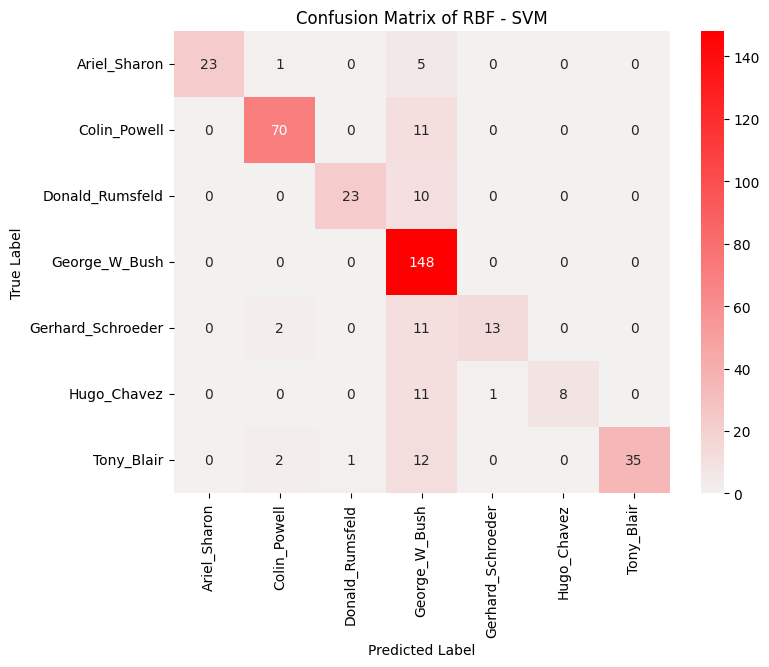

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rbf)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of RBF - SVM')
plt.show()


In [37]:


# Define parameter grids for each SVM kernel type
param_grid_linear = {
    'C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter C
}

param_grid_poly = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter C
    'degree': [2, 3, 4],  # Polynomial degree
}

param_grid_rbf = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter C
    'gamma': [0.001, 0.01, 0.1, 1, 10]  # RBF kernel width
}

# Perform grid search for each SVM kernel type
grid_search_linear = GridSearchCV(estimator=SVC(kernel='linear'), param_grid=param_grid_linear, cv=5, scoring='accuracy')
grid_search_linear.fit(X_train, y_train)
print("Best parameters for Linear SVM:", grid_search_linear.best_params_)

grid_search_poly = GridSearchCV(estimator=SVC(kernel='poly'), param_grid=param_grid_poly, cv=5, scoring='accuracy')
grid_search_poly.fit(X_train, y_train)
print("Best parameters for Polynomial SVM:", grid_search_poly.best_params_)

grid_search_rbf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid_rbf, cv=5, scoring='accuracy')
grid_search_rbf.fit(X_train, y_train)
print("Best parameters for RBF SVM:", grid_search_rbf.best_params_)


Best parameters for Linear SVM: {'C': 0.1}
Best parameters for Polynomial SVM: {'C': 10, 'degree': 3}
Best parameters for RBF SVM: {'C': 100, 'gamma': 0.001}


In [38]:
print("Accuracy for the best parameters for linear svm", accuracy_score(y_test,grid_search_linear.predict(X_test)))
print("Accuracy for the best parameters for polynomial svm", accuracy_score(y_test,grid_search_poly.predict(X_test)))
print("Accuracy for the best parameters for rbf svm", accuracy_score(y_test,grid_search_rbf.predict(X_test)))

Accuracy for the best parameters for linear svm 0.8294573643410853
Accuracy for the best parameters for polynomial svm 0.7235142118863049
Accuracy for the best parameters for rbf svm 0.8268733850129198


In [39]:
from sklearn.preprocessing import LabelEncoder

# Convert class labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(np.unique(y_train_encoded))

from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred_mlp = mlp_classifier.predict(X_test)

# Convert predictions back to original labels


# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_mlp)
print("Accuracy using ANN of sklearn", accuracy)

from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=15, batch_size=32, verbose=1,validation_split=0.2)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Accuracy using ANN of tensorflow keras", accuracy)

[0 1 2 3 4 5 6]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy using ANN of sklearn 0.8242894056847545
Epoch 1/15
23/23 [==============================] - 1s 12ms/step - loss: 1.5657 - accuracy: 0.5236 - val_loss: 1.1540 - val_accuracy: 0.6409
Epoch 2/15
23/23 [==============================] - 0s 4ms/step - loss: 0.9560 - accuracy: 0.7097 - val_loss: 0.8276 - val_accuracy: 0.7569
Epoch 3/15
23/23 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.8125 - val_loss: 0.7082 - val_accuracy: 0.7901
Epoch 4/15
23/23 [==============================] - 0s 3ms/step - loss: 0.6096 - accuracy: 0.8292 - val_loss: 0.6825 - val_accuracy: 0.7790
Epoch 5/15
23/23 [==============================] - 0s 4ms/step - loss: 0.5665 - accuracy: 0.8306 - val_loss: 0.6670 - val_accuracy: 0.7735
Epoch 6/15
23/23 [==============================] - 0s 4ms/step - loss: 0.5366 - accuracy: 0.8361 - val_loss: 0.6716 - val_accuracy: 0.7845
Epoch 7/15
23/23 [==============================] - 0s 5ms/step - loss: 0.5236 - accuracy: 0.8306 - val_loss: 

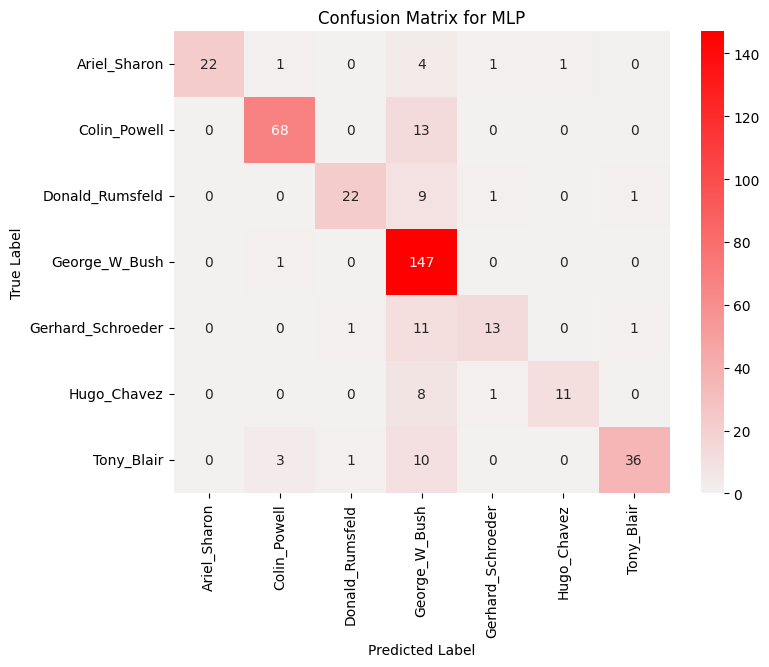

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix

conf_matrix = confusion_matrix(y_test_encoded, y_pred_mlp)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MLP')
plt.show()


In [41]:
y_pred_mlpt=model.predict(X_test)

# Find the index of the maximum value along each row
l=[]
for i in range(y_pred_mlpt.shape[0]):

      max_index = np.argmax(y_pred_mlpt[i], axis=0)
      l.append(max_index)

# Reshape max_indices to have shape (387, 1)
l=np.array(l)
y_pred_mlpt = l.reshape(-1,1)

13/13 [==============================] - 0s 3ms/step


In [42]:
y_pred_mlpt.shape

(387, 1)

In [43]:
y_test_encoded.shape

(387,)

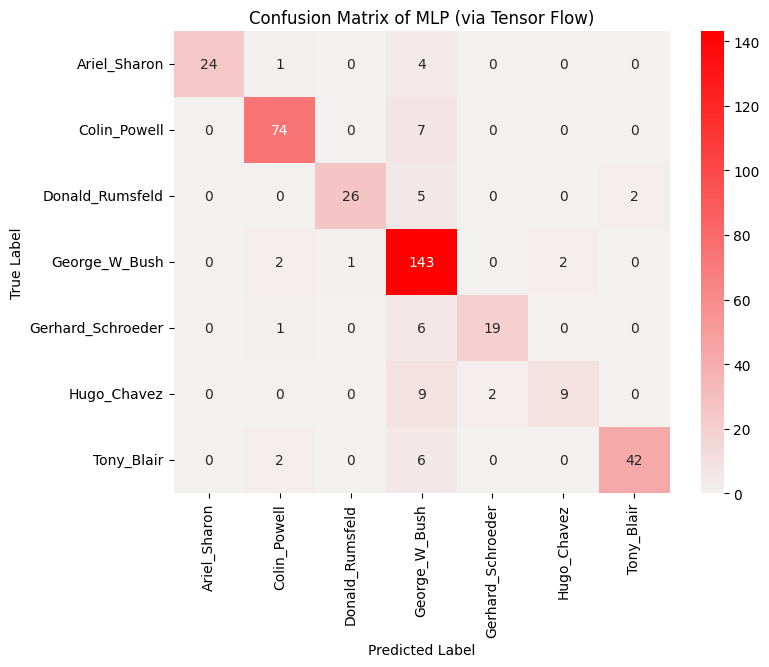

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_mlpt)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of MLP (via Tensor Flow)')
plt.show()
